In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from numpy.linalg import inv



# Dataset preparation

In [33]:
''' Prepare a dataset '''

# data belonging to Class1
X1 = multivariate_normal.rvs(mean=[1, 1], cov=[[1, 0], [0, 1]], size=100)

# data belonging to Class2
X2 = multivariate_normal.rvs(mean=[-1, -1], cov=[[1, 0], [0, 1]], size=100)

# data 
X = np.concatenate([X1, X2], axis=0)

# Target 
T = np.concatenate([np.zeros(len(X1)), np.ones(len(X2))], axis=0)

# Number of data
N = len(T)



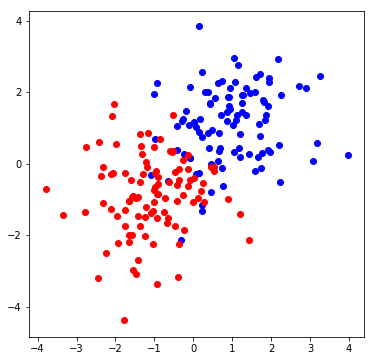

In [34]:
''' Draw dataset '''

plt.figure(figsize=[6, 6])
plt.scatter(X1[:, 0], X1[:, 1], color='b')
plt.scatter(X2[:, 0], X2[:, 1], color='r')
plt.show()



# Related functions declaration

In [35]:
''' sigmoid logistic function (10.134) '''

def logistic(x):
    return 1. / (1 + np.exp(-x))


''' lambda function (10.150) '''

def get_lambda(variational_parameters):
    v = variational_parameters
    return 1. / (2. * v) * (logistic(v) - 0.5)



In [36]:
''' Gaussian Variational Posterior (10.156-158) '''

def get_posterior(m_0, covariance_0, variational_parameters, X, T):
    
    # [N, dim, dim]
    data_covariance = X[:, :, None] @ np.transpose(X[:, :, None], axes=[0, 2, 1])
    
    # [N]
    lambda_ = get_lambda(variational_parameters)
    
    # [dim, dim]
    covariance_N_inverse = inv(covariance_0) + 2. * np.sum(lambda_[:, None, None] * data_covariance, axis=0)
    
    # [dim, dim]
    covariance_N = inv(covariance_N_inverse)
    
    # [dim, dim]
    covariance_0_inverse = inv(covariance_0)
    
    # [dim]
    m_N = covariance_N @ (covariance_0_inverse @ m_0 + np.sum((T - 0.5)[:, None] * X, axis=0))
    
    return m_N, covariance_N

    

In [37]:
''' Variational parameters optimization and Find the posterior distribution '''

def optimize_variational_parameters(X, T, variational_parameters, m_0, covariance_0, iter=100):
        
    for _ in range(iter):
        # E-Step : Expectation q(w) = N(w | m_N, S_N)
        
        m_N, S_N = get_posterior(m_0, covariance_0, variational_parameters, X, T)

        # M-Step : Maximization lower-bound (10.163)
        
        variational_parameters_square = X @ (S_N + m_N[:, None] @ m_N[:, None].T) @ X.T
        variational_parameters = np.sqrt(np.diag(variational_parameters_square))
        
    return variational_parameters, m_N, S_N

In [38]:
''' Find the predictive distribution for class C1 (4.145-4.155) '''

def predicted_probability(X_new, variational_parameters, m_N, S_N):
    
    # (4.149)
    mu_a = np.sum(m_N * X_new)
    
    # (4.150)
    variance_a = (X_new[None, :] @ S_N @ X_new[:, None])[0, 0]
    
    # (4.154)
    def kappa(variance):
        return (1 + np.pi * variance / 8) ** 0.5
    
    # (4.155)
    return logistic(kappa(variance_a) * mu_a)
    
    

# Variational Logistic Regression 

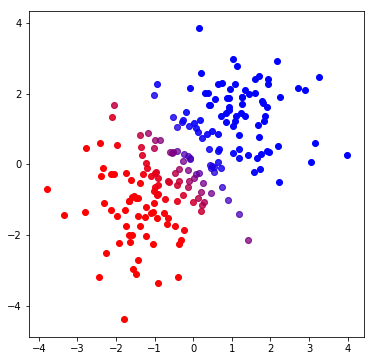

In [39]:
# Prior to weight w

m_0 = [0, 0]
S_0 = [[1, 0], [0, 1]]

# Variational parameters initialization

variational_parameters_0 = np.random.rand(N)

# Optimization variational parameters and posterior distribution using E.M. algorithm

variational_parameters, m_N, S_N = optimize_variational_parameters(X, T, variational_parameters_0, m_0, S_0)

# Draw predicton

plt.figure(figsize=[6, 6])
for x in X:
    p = predicted_probability(x, variational_parameters, m_N, S_N)
    plt.scatter(x[0], x[1], color='r', alpha=p)
    plt.scatter(x[0], x[1], color='b', alpha=(1-p))

plt.show()